In [1]:
# Comment out the following if you don't have ipympl
import matplotlib.pyplot as plt
import numpy as np
from config import CONFIG, DistributionConfig
from config.grid import GRID_CONFIG, ResetConfig, SwingConfig, MonitorConfig, NumRatioConfig
from config.rl import RL_CONFIG
from smu_grid import (Grid, NodeType, create_couplings, create_graph,
                      create_node_types, create_nodes, reset)

from config.grid import PerturbationConfig, RebalanceConfig

rng = np.random.default_rng(42)

# Create grid

In [2]:
grid = Grid(rng)
print(grid)
print()

grid.turn_on()
print(grid)


Node 0 - consumer, max: 6, active: 0
Node 1 - sink, max: 8, active: 0
Node 2 - renewable, max: 2, active: 0
Node 3 - sink, max: 2, active: 0
Node 4 - sink, max: 4, active: 0
Node 5 - consumer, max: 6, active: 0
Node 6 - renewable, max: 5, active: 0
Node 7 - generator, max: 45, active: 0
Node 8 - consumer, max: 6, active: 0
Node 9 - consumer, max: 6, active: 0
Node 10 - sink, max: 6, active: 0
Node 11 - consumer, max: 6, active: 0
Node 12 - renewable, max: 6, active: 0
Node 13 - consumer, max: 6, active: 0
Node 14 - renewable, max: 5, active: 0
Node 15 - consumer, max: 6, active: 0
Node 16 - consumer, max: 6, active: 0
Node 17 - consumer, max: 6, active: 0
Node 18 - consumer, max: 6, active: 0
Node 19 - generator, max: 45, active: 0

Node 0 - consumer, max: 6, active: 6
Node 1 - sink, max: 8, active: 5
Node 2 - renewable, max: 2, active: 1
Node 3 - sink, max: 2, active: 2
Node 4 - sink, max: 4, active: 4
Node 5 - consumer, max: 6, active: 6
Node 6 - renewable, max: 5, active: 1
Node 7 -

# Find steady state

In [3]:
# Solve swing equation and return trajectory of phase/dphase
phases, dphases = grid.run(GRID_CONFIG.steady)

time = np.arange(len(phases)) * GRID_CONFIG.steady.dt
final_time = time[-1]

if final_time < GRID_CONFIG.steady.max_time:
    print(f"Found steady state at t={final_time}")
    print(f"phase ={np.round(phases[-1], 2)}")
else:
    print("Failed to find steady state")
    print(f"Maximum velocity = {np.abs(dphases[-1]).max():.2e}")

Found steady state at t=33.410000000000004
phase =[-0.06 -0.04 -0.09 -0.04  0.02 -0.12  0.01  0.03 -0.02 -0.15  0.02 -0.16
 -0.07 -0.32 -0.14 -0.07 -0.09 -0.44 -0.16  0.19]


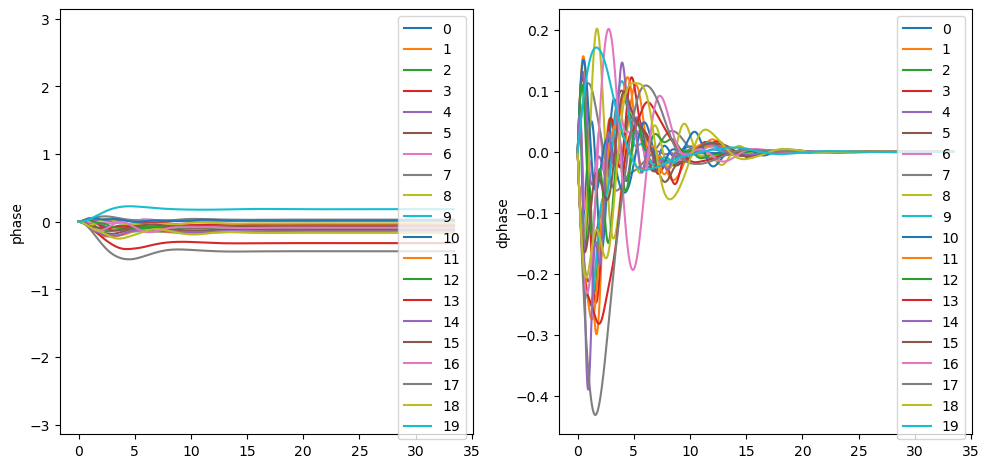

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

for i, (phase, dphase) in enumerate(zip(phases.T, dphases.T)):
    ax1.plot(time, phase, label=i)
    ax2.plot(time, dphase, label=i)

ax1.legend()
ax1.set_ylabel("phase")
ax1.set_ylim(-np.pi, np.pi)
ax2.legend()
ax2.set_ylabel("dphase")

fig.tight_layout()
fig.show()

# (Power) Perturbation and Rebalance

In [5]:
# Create an perturbation configuration object and use it
perturbations = grid.mark_perturbations()

print("Perturbation will occur as follows")
for i, (node, perturbation) in enumerate(zip(grid.nodes, perturbations)):
    if perturbation == 0:
        continue
    print(f"node {i}: {node} will perturabate {perturbation}")

grid.perturbate(perturbations)
print("\nAfter perturbation")
print(f"{grid.power_imbalance=}")
print(grid)

Perturbation will occur as follows
node 0: consumer, max: 6, active: 6 will perturabate -1

After perturbation
grid.power_imbalance=1
Node 0 - consumer, max: 6, active: 5
Node 1 - sink, max: 8, active: 5
Node 2 - renewable, max: 2, active: 1
Node 3 - sink, max: 2, active: 2
Node 4 - sink, max: 4, active: 4
Node 5 - consumer, max: 6, active: 6
Node 6 - renewable, max: 5, active: 1
Node 7 - generator, max: 45, active: 19
Node 8 - consumer, max: 6, active: 5
Node 9 - consumer, max: 6, active: 5
Node 10 - sink, max: 6, active: 6
Node 11 - consumer, max: 6, active: 6
Node 12 - renewable, max: 6, active: 2
Node 13 - consumer, max: 6, active: 6
Node 14 - renewable, max: 5, active: 1
Node 15 - consumer, max: 6, active: 6
Node 16 - consumer, max: 6, active: 6
Node 17 - consumer, max: 6, active: 6
Node 18 - consumer, max: 6, active: 6
Node 19 - generator, max: 45, active: 17


In [6]:
# Use rebalance method
rebalance_config = RebalanceConfig(_strategy="undirected", max_trials=1000)

balanced = False
while not balanced:
    # Create any weights that is compatible with rebalance config
    weights = rng.uniform(-1.0, 1.0, size=grid.num_nodes).astype(np.float32)
    weights *= (grid.is_generator + grid.is_sink)
    balanced = grid.rebalance(rebalance_config, weights)

# Manually do rebalance
# grid.nodes[4].increase()

print("After rebalancing")
print(f"{grid.power_imbalance=}")
print(grid)


After rebalancing
grid.power_imbalance=0
Node 0 - consumer, max: 6, active: 5
Node 1 - sink, max: 8, active: 5
Node 2 - renewable, max: 2, active: 1
Node 3 - sink, max: 2, active: 2
Node 4 - sink, max: 4, active: 4
Node 5 - consumer, max: 6, active: 6
Node 6 - renewable, max: 5, active: 1
Node 7 - generator, max: 45, active: 18
Node 8 - consumer, max: 6, active: 5
Node 9 - consumer, max: 6, active: 5
Node 10 - sink, max: 6, active: 6
Node 11 - consumer, max: 6, active: 6
Node 12 - renewable, max: 6, active: 2
Node 13 - consumer, max: 6, active: 6
Node 14 - renewable, max: 5, active: 1
Node 15 - consumer, max: 6, active: 6
Node 16 - consumer, max: 6, active: 6
Node 17 - consumer, max: 6, active: 6
Node 18 - consumer, max: 6, active: 6
Node 19 - generator, max: 45, active: 17


In [7]:
# Solve swing equation and return trajectory of phase/dphase
perturbated_phases, perturbated_dphases = grid.run(
    config=CONFIG.grid.steady, phase=phases[-1]
)

time = np.arange(len(perturbated_phases)) * GRID_CONFIG.steady.dt
final_time = time[-1]

if final_time < GRID_CONFIG.steady.max_time:
    print(f"Found steady state at t={final_time}")
    print(f"phase ={np.round(perturbated_phases[-1], 2)}")
else:
    print("Failed to find steady state")
    print(f"Maximum velocity = {np.abs(perturbated_dphases[-1]).max():.2e}")

Found steady state at t=18.1
phase =[-0.05 -0.04 -0.08 -0.04  0.02 -0.12  0.01  0.03 -0.03 -0.15  0.02 -0.15
 -0.07 -0.32 -0.14 -0.07 -0.09 -0.44 -0.16  0.19]


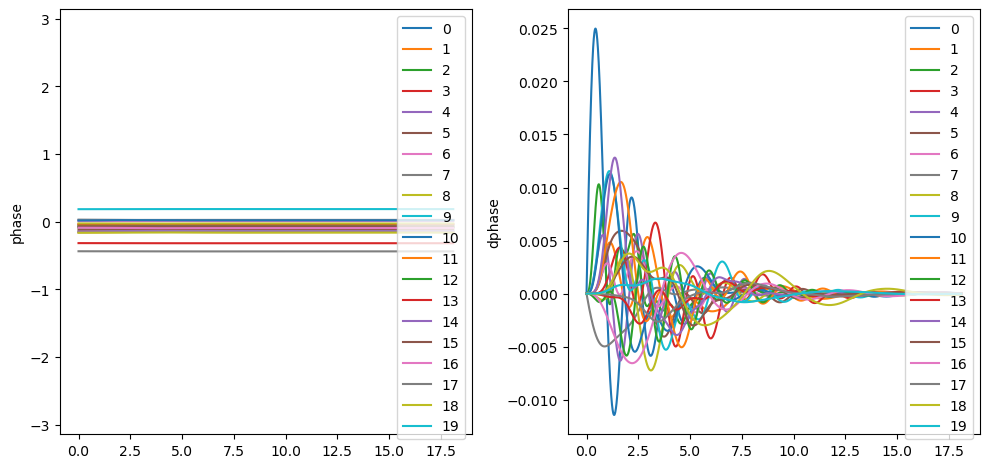

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

for i, (phase, dphase) in enumerate(zip(perturbated_phases.T, perturbated_dphases.T)):
    ax1.plot(time, phase, label=i)
    ax2.plot(time, dphase, label=i)

ax1.legend()
ax1.set_ylabel("phase")
ax1.set_ylim(-np.pi, np.pi)
ax2.legend()
ax2.set_ylabel("dphase")

fig.tight_layout()
fig.show()
